In [2]:
# !nvidia-smi --query
!nvidia-smi -L

GPU 0: NVIDIA GeForce GTX 1080 Ti (UUID: GPU-51e53a31-5fb4-2fc0-d302-b0fd5c7dfbc9)


In [3]:
# !pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
# !gcc --version

c:\softz\venv\potato\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.10.0+cu113 True


In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
# from google.colab.patches import cv2_imshow
from tqdm import tqdm
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog, DatasetMapper, build_detection_train_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
import detectron2.data.transforms as T
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from detectron2.checkpoint import DetectionCheckpointer, PeriodicCheckpointer

In [5]:
from detectron2.data.datasets import register_coco_instances
datasets=[]
datasets_test=[]
INDEX=['1','2','3','4','5','6','8','14','15','17','18','19','20','25','26']
# for i in INDEX:
#   datasets.append("potato{}_dataset_train".format(i))
############################## val ######################################
register_coco_instances("potato2_dataset_test", {}, "c:/softz/potato/dataset/set2/test/potato_set2_coco.json", "c:/softz/potato/dataset/set2/test/images")
# register_coco_instances("potato3_dataset_test", {}, "/content/drive/MyDrive/softz/mrcnn/potato/dataset/set3/test/potato_set3_coco.json", "/content/drive/MyDrive/softz/mrcnn/potato/dataset/set3/test/images")
# register_coco_instances("potato4_dataset_test", {}, "/content/drive/MyDrive/softz/mrcnn/potato/dataset/set4/test/potato_set4_coco.json", "/content/drive/MyDrive/softz/mrcnn/potato/dataset/set4/test/images")
# register_coco_instances("potato5_dataset_test", {}, "/content/drive/MyDrive/softz/mrcnn/potato/dataset/set5/test/potato_set5_coco.json", "/content/drive/MyDrive/softz/mrcnn/potato/dataset/set5/test/images")
# register_coco_instances("potato12_dataset_test", {}, "/content/drive/MyDrive/softz/mrcnn/potato/dataset/set12/test/potato_set12_coco.json", "/content/drive/MyDrive/softz/mrcnn/potato/dataset/set12/test/images")
# register_coco_instances("potato13_dataset_test", {}, "/content/drive/MyDrive/softz/mrcnn/potato/dataset/set13/test/potato_set13_coco.json", "/content/drive/MyDrive/softz/mrcnn/potato/dataset/set13/test/images")



In [7]:
root_path='c:/softz/potato/dataset/'
coco_instances_tmpl="potato{}_dataset_train"
coco_file_tmpl='set{}/train/potato_set{}_coco.json'
images_tmpl='set{}/train/images'

COUNTER=8
for i in INDEX:
  coco_instances=coco_instances_tmpl.format(i)
  coco_file=coco_file_tmpl.format(i,i)
  images=images_tmpl.format(i)
  register_coco_instances(coco_instances, {}, '{}{}'.format(root_path, coco_file), '{}{}'.format(root_path, images))
  datasets.append(coco_instances)
print(datasets)

['potato1_dataset_train', 'potato2_dataset_train', 'potato3_dataset_train', 'potato4_dataset_train', 'potato5_dataset_train', 'potato6_dataset_train', 'potato8_dataset_train', 'potato14_dataset_train', 'potato15_dataset_train', 'potato17_dataset_train', 'potato18_dataset_train', 'potato19_dataset_train', 'potato20_dataset_train', 'potato25_dataset_train', 'potato26_dataset_train']


In [32]:
# root_path='/content/drive/MyDrive/softz/mrcnn/potato/dataset/'
# coco_instances_tmpl="potato{}a{}_dataset_train"
# coco_file_tmpl='set{}a{}/train/potato_set{}_coco.json'
# images_tmpl='set{}a{}/train/images'

# COUNTER=8
# for i in INDEX:
#   for j in range(COUNTER):
#     coco_instances=coco_instances_tmpl.format(i,j)
#     coco_file=coco_file_tmpl.format(i,j,i)
#     images=images_tmpl.format(i,j)
#     register_coco_instances(coco_instances, {}, '{}{}'.format(root_path, coco_file), '{}{}'.format(root_path, images))
#     datasets.append(coco_instances)
# print(datasets)

['potato1_dataset_train', 'potato2_dataset_train', 'potato3_dataset_train', 'potato4_dataset_train', 'potato5_dataset_train', 'potato6_dataset_train', 'potato8_dataset_train', 'potato14_dataset_train', 'potato15_dataset_train', 'potato17_dataset_train', 'potato18_dataset_train', 'potato19_dataset_train', 'potato20_dataset_train', 'potato25_dataset_train', 'potato26_dataset_train', 'potato1a0_dataset_train', 'potato1a1_dataset_train', 'potato1a2_dataset_train', 'potato1a3_dataset_train', 'potato1a4_dataset_train', 'potato1a5_dataset_train', 'potato1a6_dataset_train', 'potato1a7_dataset_train', 'potato2a0_dataset_train', 'potato2a1_dataset_train', 'potato2a2_dataset_train', 'potato2a3_dataset_train', 'potato2a4_dataset_train', 'potato2a5_dataset_train', 'potato2a6_dataset_train', 'potato2a7_dataset_train', 'potato3a0_dataset_train', 'potato3a1_dataset_train', 'potato3a2_dataset_train', 'potato3a3_dataset_train', 'potato3a4_dataset_train', 'potato3a5_dataset_train', 'potato3a6_dataset_tra

In [8]:
# test dataset
INDEX_TEST=['3','4','5','12','13','19']
# INDEX_TEST=['19']

# root_path='/content/drive/MyDrive/softz/mrcnn/potato/dataset/'
coco_instances_tmpl="potato{}_dataset_test"
coco_file_tmpl='set{}/test/potato_set{}_coco.json'
images_tmpl='set{}/test/images'

for i in INDEX_TEST:
  coco_instances=coco_instances_tmpl.format(i)
  coco_file=coco_file_tmpl.format(i,i)
  images=images_tmpl.format(i)
  register_coco_instances(coco_instances, {}, '{}{}'.format(root_path, coco_file), '{}{}'.format(root_path, images))
  datasets_test.append(coco_instances)
datasets_test.append("potato2_dataset_test")
print(datasets_test)

['potato3_dataset_test', 'potato4_dataset_test', 'potato5_dataset_test', 'potato12_dataset_test', 'potato13_dataset_test', 'potato19_dataset_test', 'potato2_dataset_test']


In [9]:
os.environ['root_path'] = 'c:/softz/potato/weights'
os.environ['date_part'] = '202205021400'

In [10]:
import copy
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
class myMapper:
    def __init__(self, cfg, is_train: bool = True):
        if is_train:
            aug_list = [
                        T.ResizeShortestEdge([800, 800], sample_style='range'),
                        T.RandomBrightness(0.8, 1.2),
                        T.RandomRotation([0.5, 1]),
                        T.RandomContrast(0.8, 1.2),
                        T.RandomSaturation(0.8, 1.2),
                        T.RandomFlip(prob=0.5, horizontal=True, vertical=False)
                        ]
        else:
            aug_list = [T.ResizeShortestEdge(800, sample_style='choice')]
                        
        self.augmentations = T.AugmentationList(aug_list)
        self.is_train = is_train
        mode = "training" if is_train else "inference"
        print(f"[MyDatasetMapper] Augmentations used in {mode}: {self.augmentations}")
        
    def __call__(self, dataset_dict):
        dataset_dict = copy.deepcopy(dataset_dict)
        image = utils.read_image(dataset_dict["file_name"], format="BGR")

        aug_input = T.AugInput(image)
        transforms = self.augmentations(aug_input)
        image = aug_input.image
        image_shape = image.shape[:2]  # h, w
        dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))
        annos = [
            utils.transform_instance_annotations(obj, transforms, image_shape)
            for obj in dataset_dict.pop("annotations")
            if obj.get("iscrowd", 0) == 0
        ]
        instances = utils.annotations_to_instances(annos, image_shape)
        dataset_dict["instances"] = utils.filter_empty_instances(instances)
        return dataset_dict

In [11]:
import pandas as pd
import logging
from madgrad import MADGRAD
import detectron2.utils.comm as comm
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from detectron2.utils.events import EventWriter, get_event_storage
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
from detectron2.modeling import build_model
from detectron2.solver import build_lr_scheduler, build_optimizer
from detectron2.utils.events import EventStorage
logger = logging.getLogger("detectron2")
from detectron2.engine import default_argument_parser, default_setup, default_writers, launch
import shutil

In [12]:
# use default COCO evaluator
def get_evaluator(cfg, dataset_name, output_folder=None):
    if output_folder is None:
        output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
    return COCOEvaluator(dataset_name, ("bbox",), False, output_dir=output_folder,use_fast_impl=True)

In [13]:
def train_model(cfg, resume=False):
    # Data loader
    dataset_names = [d_names for d_names in cfg.DATASETS.TEST]
    print(f'dataset_names={dataset_names}')
    train_loader = build_detection_train_loader(cfg, mapper=myMapper(cfg,is_train=True))
#     dataset_name = cfg.DATASETS.TEST[0]
#     valid_loader = build_detection_test_loader(cfg, dataset_name, mapper=myMapper(cfg,is_train=False))
    
    # Model, optimizer, scheduler
    model = build_model(cfg)
    optimizer = MADGRAD(model.parameters(), lr=cfg.SOLVER.BASE_LR, weight_decay=cfg.SOLVER.WEIGHT_DECAY, momentum = cfg.SOLVER.MOMENTUM)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=cfg.SOLVER.GAMMA, patience=2, verbose=True, eps=1e-8)
    
    # Checkpoint
    checkpointer = DetectionCheckpointer(model, cfg.OUTPUT_DIR, optimizer=optimizer, scheduler=scheduler)
    start_iter = (checkpointer.resume_or_load(cfg.MODEL.WEIGHTS, resume=resume).get("iteration", -1) + 1)
    max_iter = cfg.SOLVER.MAX_ITER
    periodic_checkpointer = PeriodicCheckpointer(checkpointer, cfg.SOLVER.CHECKPOINT_PERIOD, max_iter=max_iter)
    
    # Use a writer to record loss and common metrics
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    writers = default_writers(cfg.OUTPUT_DIR, max_iter)
    # writers.append(WAndBWriter()) 
    
    # Help to record validation results
    best_mAP = 0
    valid_AP = []
    # Train loop
    model.train()
    with EventStorage(start_iter) as storage:
        for data, iteration in zip(train_loader, range(start_iter, max_iter)):
            storage.iter = iteration
            loss_dict = model(data) # Four types of loss obtained from the faster rcnn model
            losses = sum(loss_dict.values())
            loss_dict_reduced = {k: v.item() for k, v in comm.reduce_dict(loss_dict).items()}
            losses_reduced = sum(loss for loss in loss_dict_reduced.values())
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            
            # store the loss and lr
            storage.put_scalars(total_loss=losses_reduced, **loss_dict_reduced)
            storage.put_scalar("lr", optimizer.param_groups[0]["lr"], smoothing_hint=False)
            # print(f'losses_reduced={losses_reduced}, lr={optimizer.param_groups[0]["lr"]}')
            if (iteration % 100 == 0):
              logger.info(f'iter={iteration}, losses_reduced={losses_reduced}, lr={optimizer.param_groups[0]["lr"]}')
            
            # validation
            if (cfg.TEST.EVAL_PERIOD > 0 and (iteration + 1) % cfg.TEST.EVAL_PERIOD == 0):
                checkpointer.save("potato_model_current")
                shutil.copy('./output/potato_model_current.pth', os.environ['root_path'] + '/potato_model_current_' + os.environ['date_part'] + '.pth')
                output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
                for dataset_name in dataset_names:
                    valid_loader = build_detection_test_loader(cfg, dataset_name, mapper=myMapper(cfg,is_train=False))
                    evaluator = get_evaluator(cfg, dataset_name, os.path.join(cfg.OUTPUT_DIR, "inference"))
                    eval_stat = inference_on_dataset(model, valid_loader, evaluator)
                    mAP = list(eval_stat.values())[0]['AP']
                    if mAP > best_mAP:
                        best_mAP = mAP
                        checkpointer.save("best_mAP")
                        logger.info(f'Save Best Score: {best_mAP:.4f}')
                        shutil.copy('./output/best_mAP.pth', os.environ['root_path'] + '/potato_model_best_' + os.environ['date_part'] + '.pth')
                        shutil.copy('./output/metrics.json', os.environ['root_path'] + '/metrics_' + os.environ['date_part'] + '.json')
                scheduler.step(mAP)
                # wandb.log({'eval-mAP': mAP, 
                #            'eval-AP50': list(eval_stat.values())[0]['AP50'],
                #            'eval-AP75': list(eval_stat.values())[0]['AP75'],
                #            'eval-APs': list(eval_stat.values())[0]['APs'],
                #            'eval-APm': list(eval_stat.values())[0]['APm'],
                #            'eval-APl': list(eval_stat.values())[0]['APl'],
                #            'eval-belt': list(eval_stat.values())[0]['AP-belt'],
                #            'eval-boot': list(eval_stat.values())[0]['AP-boot'],
                #            'eval-cowboy_hat': list(eval_stat.values())[0]['AP-cowboy_hat'],
                #            'eval-jacket': list(eval_stat.values())[0]['AP-jacket'],
                #            'eval-sunglasses': list(eval_stat.values())[0]['AP-sunglasses'],
                #            'global_step': storage.iter,
                #           })
                valid_AP.append(list(eval_stat.values())[0])
                for writer in writers:
                    writer.write()
    return pd.DataFrame.from_dict(valid_AP)   


In [21]:
# from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (tuple(datasets))
cfg.DATASETS.TEST = (tuple(datasets_test))
cfg.DATALOADER.NUM_WORKERS = 2 # denotes the number of processes that generate batches in parallel
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.MODEL.WEIGHTS = './output/potato_model_current.pth'
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # only has one class . (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# cfg.INPUT.FORMAT='RGB'
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.GAMMA = 0.5
cfg.SOLVER.BASE_LR = 5e-06
# cfg.SOLVER.WEIGHT_DECAY = 0
cfg.SOLVER.MAX_ITER = 14300  #adjust up if val mAP is still rising, adjust down if overfit
# cfg.SOLVER.STEPS = (1000, 1500, 2000, 2500, 2800, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500,)
cfg.SOLVER.WARMUP_FACTOR = 1.0 / 200
cfg.SOLVER.WARMUP_ITERS = 200
cfg.TEST.EVAL_PERIOD = 4000
# cfg.SOLVER.CHECKPOINT_PERIOD = 2000  # Small value=Frequent save need a lot of storage.
#---------------------------
cfg.SOLVER.WARMUP_METHOD = "linear"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = CocoTrainer(cfg)
# trainer = DefaultTrainer(cfg)
# # DefaultTrainer.test(cfg)
# dataloader = trainer.build_train_loader(cfg) #  test() missing 1 required positional argument: 'model'
# trainer.resume_or_load(resume=False)
# trainer.train()

In [13]:
f = open('config.yml', 'w')
f.write(cfg.dump())
f.close()

In [14]:
# os.environ['root_path'] = '/content/drive/MyDrive/softz/mrcnn/potato/weights'
# %env date_part = 202204271700
# %env video_out = video/out/
# !cp ./output/best_mAP.pth $root_path/potato_model_final_$date_part.pth
shutil.copy('./config.yml', os.environ['root_path'] + '/config_' + os.environ['date_part'] + '.yml')
# !cp ./output/metrics.json $root_path/metrics_$date_part.json


'c:/softz/potato/weights/config_202205021400.yml'

In [23]:
# cfg.OUTPUT_DIR = './model/cv0'
# run = wandb.init(project="cowboy_kaggle_temp", name="fold0_temp", sync_tensorboard=True)
valid_AP = train_model(cfg, resume=True)

dataset_names=['potato3_dataset_test', 'potato4_dataset_test', 'potato5_dataset_test', 'potato12_dataset_test', 'potato13_dataset_test', 'potato19_dataset_test', 'potato2_dataset_test']
[MyDatasetMapper] Augmentations used in training: AugmentationList[ResizeShortestEdge(short_edge_length=[800, 800]), RandomBrightness(intensity_min=0.8, intensity_max=1.2), RandomRotation(angle=[0.5, 1]), RandomContrast(intensity_min=0.8, intensity_max=1.2), RandomSaturation(intensity_min=0.8, intensity_max=1.2), RandomFlip(prob=0.5)]
[05/02 15:15:59 d2.data.datasets.coco]: Loaded 59 images in COCO format from c:/softz/potato/dataset/set1/train/potato_set1_coco.json
[05/02 15:15:59 d2.data.datasets.coco]: Loaded 624 images in COCO format from c:/softz/potato/dataset/set2/train/potato_set2_coco.json
[05/02 15:15:59 d2.data.datasets.coco]: Loaded 672 images in COCO format from c:/softz/potato/dataset/set3/train/potato_set3_coco.json
[05/02 15:15:59 d2.data.datasets.coco]: Loaded 704 images in COCO format 

[05/02 15:16:13 detectron2]: iter=0, losses_reduced=0.03419853267041617, lr=5e-06
[05/02 15:17:13 detectron2]: iter=100, losses_reduced=0.04173622118287312, lr=5e-06
[05/02 15:18:12 detectron2]: iter=200, losses_reduced=0.03399104818890919, lr=5e-06
[05/02 15:19:12 detectron2]: iter=300, losses_reduced=0.042586089482938405, lr=5e-06
[05/02 15:20:11 detectron2]: iter=400, losses_reduced=0.04264651994162705, lr=5e-06
[05/02 15:21:09 detectron2]: iter=500, losses_reduced=0.02197015432648186, lr=5e-06
[05/02 15:22:08 detectron2]: iter=600, losses_reduced=0.10041314636328025, lr=5e-06
[05/02 15:23:08 detectron2]: iter=700, losses_reduced=0.05597203082470514, lr=5e-06
[05/02 15:24:07 detectron2]: iter=800, losses_reduced=0.03325463160581421, lr=5e-06
[05/02 15:25:07 detectron2]: iter=900, losses_reduced=0.04070007161953981, lr=5e-06
[05/02 15:26:05 detectron2]: iter=1000, losses_reduced=0.045819118418876315, lr=5e-06
[05/02 15:27:03 detectron2]: iter=1100, losses_reduced=0.03663306437374558,

[05/02 15:56:13 detectron2]: Save Best Score: 60.5373
[MyDatasetMapper] Augmentations used in inference: AugmentationList[ResizeShortestEdge(short_edge_length=(800, 800), sample_style='choice')]
[05/02 15:56:16 d2.data.datasets.coco]: Loaded 200 images in COCO format from c:/softz/potato/dataset/set4/test/potato_set4_coco.json
[05/02 15:56:16 d2.data.build]: Distribution of instances among all 3 categories:
|   category    | #instances   |  category   | #instances   |  category   | #instances   |
|:-------------:|:-------------|:-----------:|:-------------|:-----------:|:-------------|
| potato_strong | 415          | potato_sick | 0            | black_stone | 0            |
|               |              |             |              |             |              |
|     total     | 415          |             |              |             |              |
[05/02 15:56:16 d2.data.common]: Serializing 200 elements to byte tensors and concatenating them all ...
[05/02 15:56:16 d2.data.commo

[05/02 15:57:17 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[05/02 15:57:17 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category      | AP     | category    | AP   | category    | AP   |
|:--------------|:-------|:------------|:-----|:------------|:-----|
| potato_strong | 47.954 | potato_sick | nan  | black_stone | nan  |
[MyDatasetMapper] Augmentations used in inference: AugmentationList[ResizeShortestEdge(short_edge_length=(800, 800), sample_style='choice')]
[05/02 15:57:17 d2.data.datasets.coco]: Loaded 15 images in COCO format from c:/softz/potato/dataset/set12/test/potato_set12_coco.json
[05/02 15:57:17 d2.data.build]: Distribution of instances among all 3 categories:
|   category    | #instances   |  category   | #instances   |  category   | #instances   |
|:-------------:|:-------------|:-----------:|:-------------|:-----------:|:-------------|
| potato_strong | 138          | potato_sick | 1            | black_stone | 9    

[05/02 15:57:53 d2.data.build]: Distribution of instances among all 3 categories:
|   category    | #instances   |  category   | #instances   |  category   | #instances   |
|:-------------:|:-------------|:-----------:|:-------------|:-----------:|:-------------|
| potato_strong | 1002         | potato_sick | 0            | black_stone | 0            |
|               |              |             |              |             |              |
|     total     | 1002         |             |              |             |              |
[05/02 15:57:53 d2.data.common]: Serializing 500 elements to byte tensors and concatenating them all ...
[05/02 15:57:53 d2.data.common]: Serialized dataset takes 1.03 MiB
[05/02 15:57:53 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[05/02 15:57:53 d2.evaluation.evaluator]: Start inference on 500 batches
[05/02 15:57:59 d2.evaluation.evaluator]: Inference done 11/500. Dataloading: 0.0014 s/iter. Inference: 0

[05/02 15:59:42 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.560
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.773
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.575
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.111
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.619
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.431
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.605
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= 

DONE (t=0.19s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.630
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.766
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.689
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.154
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.694
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.458
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.661
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.661
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.152
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.709
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

[05/02 16:41:10 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[05/02 16:41:10 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category      | AP     | category    | AP   | category    | AP   |
|:--------------|:-------|:------------|:-----|:------------|:-----|
| potato_strong | 42.832 | potato_sick | nan  | black_stone | nan  |
[MyDatasetMapper] Augmentations used in inference: AugmentationList[ResizeShortestEdge(short_edge_length=(800, 800), sample_style='choice')]
[05/02 16:41:10 d2.data.datasets.coco]: Loaded 15 images in COCO format from c:/softz/potato/dataset/set12/test/potato_set12_coco.json
[05/02 16:41:10 d2.data.common]: Serializing 15 elements to byte tensors and concatenating them all ...
[05/02 16:41:10 d2.data.common]: Serialized dataset takes 0.02 MiB
[05/02 16:41:10 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[05/02 16:41:10 d2.evaluation.evaluator]: Start inference on 

[05/02 16:42:06 d2.evaluation.evaluator]: Inference done 176/500. Dataloading: 0.0020 s/iter. Inference: 0.1152 s/iter. Eval: 0.0050 s/iter. Total: 0.1224 s/iter. ETA=0:00:39
[05/02 16:42:11 d2.evaluation.evaluator]: Inference done 217/500. Dataloading: 0.0020 s/iter. Inference: 0.1152 s/iter. Eval: 0.0050 s/iter. Total: 0.1223 s/iter. ETA=0:00:34
[05/02 16:42:16 d2.evaluation.evaluator]: Inference done 259/500. Dataloading: 0.0020 s/iter. Inference: 0.1150 s/iter. Eval: 0.0049 s/iter. Total: 0.1221 s/iter. ETA=0:00:29
[05/02 16:42:21 d2.evaluation.evaluator]: Inference done 301/500. Dataloading: 0.0020 s/iter. Inference: 0.1146 s/iter. Eval: 0.0050 s/iter. Total: 0.1218 s/iter. ETA=0:00:24
[05/02 16:42:26 d2.evaluation.evaluator]: Inference done 342/500. Dataloading: 0.0020 s/iter. Inference: 0.1148 s/iter. Eval: 0.0050 s/iter. Total: 0.1220 s/iter. ETA=0:00:19
[05/02 16:42:31 d2.evaluation.evaluator]: Inference done 383/500. Dataloading: 0.0020 s/iter. Inference: 0.1149 s/iter. Eval:

[05/02 16:44:14 detectron2]: iter=8100, losses_reduced=0.03234896010326338, lr=5e-06
[05/02 16:45:11 detectron2]: iter=8200, losses_reduced=0.026649589930457296, lr=5e-06
[05/02 16:46:10 detectron2]: iter=8300, losses_reduced=0.039434278618500684, lr=5e-06
[05/02 16:47:09 detectron2]: iter=8400, losses_reduced=0.03656812445478863, lr=5e-06
[05/02 16:48:06 detectron2]: iter=8500, losses_reduced=0.047432614243007265, lr=5e-06
[05/02 16:49:04 detectron2]: iter=8600, losses_reduced=0.02352687621350924, lr=5e-06
[05/02 16:50:03 detectron2]: iter=8700, losses_reduced=0.10633932694690884, lr=5e-06
[05/02 16:51:00 detectron2]: iter=8800, losses_reduced=0.04088343994044408, lr=5e-06
[05/02 16:51:57 detectron2]: iter=8900, losses_reduced=0.02934407141219708, lr=5e-06
[05/02 16:52:55 detectron2]: iter=9000, losses_reduced=0.06285595318331616, lr=5e-06
[05/02 16:53:53 detectron2]: iter=9100, losses_reduced=0.3849677387624979, lr=5e-06
[05/02 16:54:52 detectron2]: iter=9200, losses_reduced=0.061493

[05/02 17:23:09 d2.evaluation.evaluator]: Start inference on 200 batches
[05/02 17:23:16 d2.evaluation.evaluator]: Inference done 11/200. Dataloading: 0.0031 s/iter. Inference: 0.1120 s/iter. Eval: 0.0011 s/iter. Total: 0.1162 s/iter. ETA=0:00:21
[05/02 17:23:21 d2.evaluation.evaluator]: Inference done 55/200. Dataloading: 0.0021 s/iter. Inference: 0.1123 s/iter. Eval: 0.0012 s/iter. Total: 0.1158 s/iter. ETA=0:00:16
[05/02 17:23:26 d2.evaluation.evaluator]: Inference done 97/200. Dataloading: 0.0020 s/iter. Inference: 0.1138 s/iter. Eval: 0.0012 s/iter. Total: 0.1172 s/iter. ETA=0:00:12
[05/02 17:23:31 d2.evaluation.evaluator]: Inference done 140/200. Dataloading: 0.0020 s/iter. Inference: 0.1136 s/iter. Eval: 0.0012 s/iter. Total: 0.1169 s/iter. ETA=0:00:07
[05/02 17:23:36 d2.evaluation.evaluator]: Inference done 184/200. Dataloading: 0.0022 s/iter. Inference: 0.1132 s/iter. Eval: 0.0012 s/iter. Total: 0.1168 s/iter. ETA=0:00:01
[05/02 17:23:38 d2.evaluation.evaluator]: Total inferen

[05/02 17:24:29 d2.evaluation.evaluator]: Total inference time: 0:00:11.760189 (1.176019 s / iter per device, on 1 devices)
[05/02 17:24:29 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.200859 s / iter per device, on 1 devices)
[05/02 17:24:29 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[05/02 17:24:29 d2.evaluation.coco_evaluation]: Saving results to ./output\inference\coco_instances_results.json
[05/02 17:24:29 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.09s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.158
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.231
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.18

[05/02 17:25:42 d2.evaluation.evaluator]: Inference done 428/500. Dataloading: 0.0023 s/iter. Inference: 0.1140 s/iter. Eval: 0.0051 s/iter. Total: 0.1215 s/iter. ETA=0:00:08
[05/02 17:25:47 d2.evaluation.evaluator]: Inference done 469/500. Dataloading: 0.0022 s/iter. Inference: 0.1140 s/iter. Eval: 0.0052 s/iter. Total: 0.1216 s/iter. ETA=0:00:03
[05/02 17:25:51 d2.evaluation.evaluator]: Total inference time: 0:01:00.517502 (0.122258 s / iter per device, on 1 devices)
[05/02 17:25:51 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:56 (0.113945 s / iter per device, on 1 devices)
[05/02 17:25:51 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[05/02 17:25:51 d2.evaluation.coco_evaluation]: Saving results to ./output\inference\coco_instances_results.json
[05/02 17:25:51 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image e

[05/02 17:38:26 detectron2]: iter=13200, losses_reduced=0.06682094140342087, lr=2.5e-06
[05/02 17:39:26 detectron2]: iter=13300, losses_reduced=0.058672354207374156, lr=2.5e-06
[05/02 17:40:24 detectron2]: iter=13400, losses_reduced=0.017730795159877744, lr=2.5e-06
[05/02 17:41:21 detectron2]: iter=13500, losses_reduced=0.03307579303509556, lr=2.5e-06
[05/02 17:42:19 detectron2]: iter=13600, losses_reduced=0.044512711732750176, lr=2.5e-06
[05/02 17:43:18 detectron2]: iter=13700, losses_reduced=0.03170852562652726, lr=2.5e-06
[05/02 17:44:16 detectron2]: iter=13800, losses_reduced=0.05573585968863881, lr=2.5e-06
[05/02 17:45:14 detectron2]: iter=13900, losses_reduced=0.04061721901962301, lr=2.5e-06
[05/02 17:46:11 detectron2]: iter=14000, losses_reduced=0.015285829777894833, lr=2.5e-06
[05/02 17:47:09 detectron2]: iter=14100, losses_reduced=0.03440426634369942, lr=2.5e-06
[05/02 17:48:08 detectron2]: iter=14200, losses_reduced=0.040055912363641255, lr=2.5e-06


In [48]:
# clean the existing dataset before loading the next fold of data
# DatasetCatalog.clear()
# MetadataCatalog.clear()

In [29]:
# cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/softz/mrcnn/potato/weights/potato_model_final_202204251300.pth"  # path to the model we just trained
cfg.MODEL.WEIGHTS = "./output/best_mAP.pth"
# cfg.MODEL.WEIGHTS = "./output/potato_model_current.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[05/02 17:55:23 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

In [25]:
import matplotlib.pyplot as plt
def cv2_imshow(image):
    plt.imshow(image)
    plt.show()

In [26]:
from os import listdir
from os.path import isfile, join
mypath='c:/softz/potato/test/setx'
images = [f for f in listdir(mypath) if isfile(join(mypath, f))]

VID_145123_1.jpg


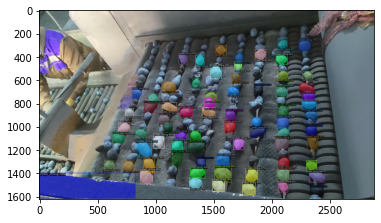

VID_145123_10.jpg


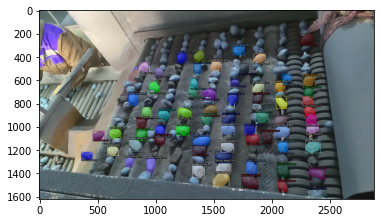

VID_145123_11.jpg


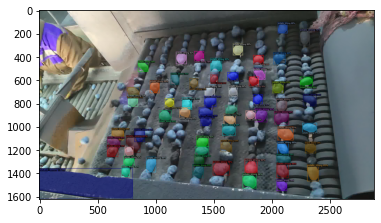

VID_145123_12.jpg


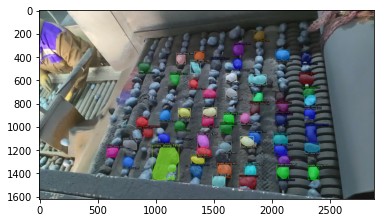

VID_145123_13.jpg


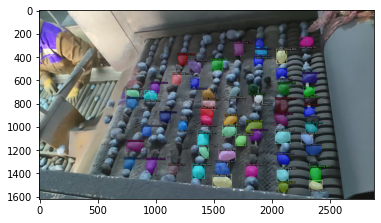

VID_145123_14.jpg


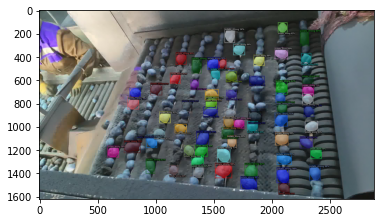

VID_145123_15.jpg


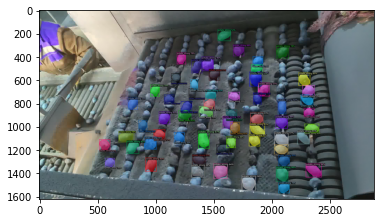

VID_145123_16.jpg


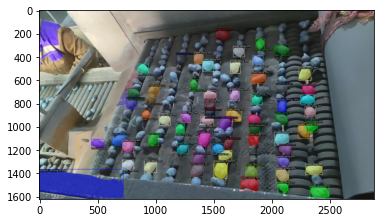

VID_145123_2.jpg


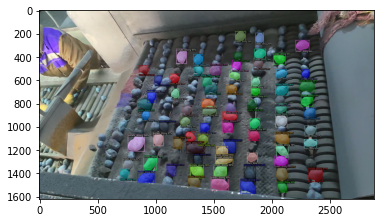

VID_145123_3.jpg


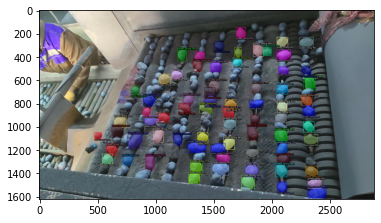

VID_145123_4.jpg


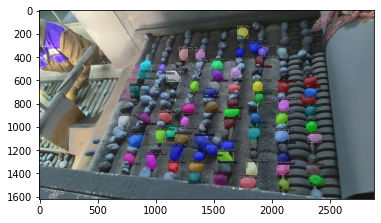

VID_145123_5.jpg


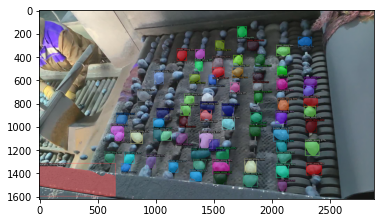

VID_145123_6.jpg


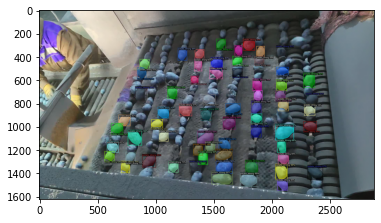

VID_145123_7.jpg


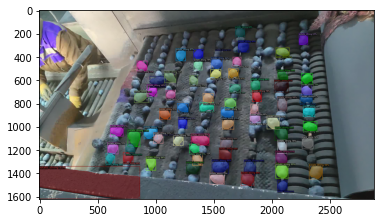

VID_145123_8.jpg


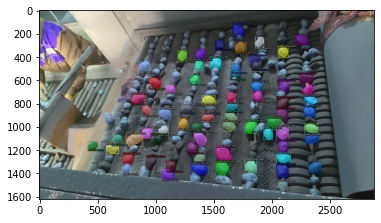

VID_145123_9.jpg


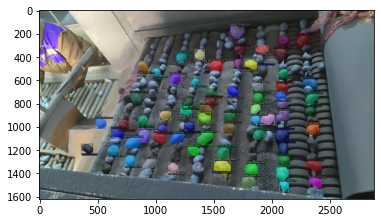

In [30]:
for image_path in images:
  image = cv2.imread('{}/{}'.format(mypath, image_path))
  print(image_path)
  outputs = predictor(image)
  v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.5)
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])